<a href="https://colab.research.google.com/github/Komal-Zia/neural/blob/main/Copy_of_Untitled17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.3 MB/s eta 0:00:00
Please upload your dataset file.


Saving IMF2.csv to IMF2 (2).csv
Dataset loaded.


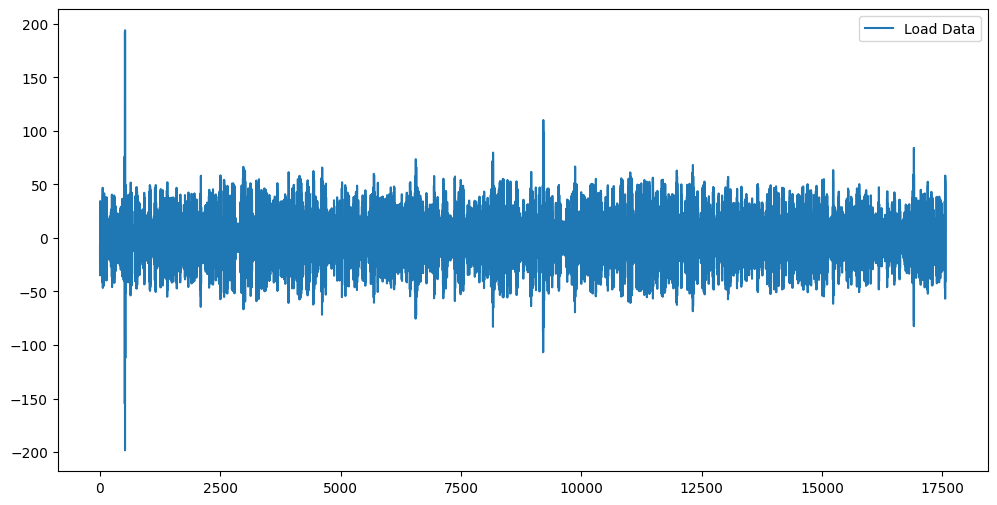

<ipython-input-4-237448ea81f5>:51: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


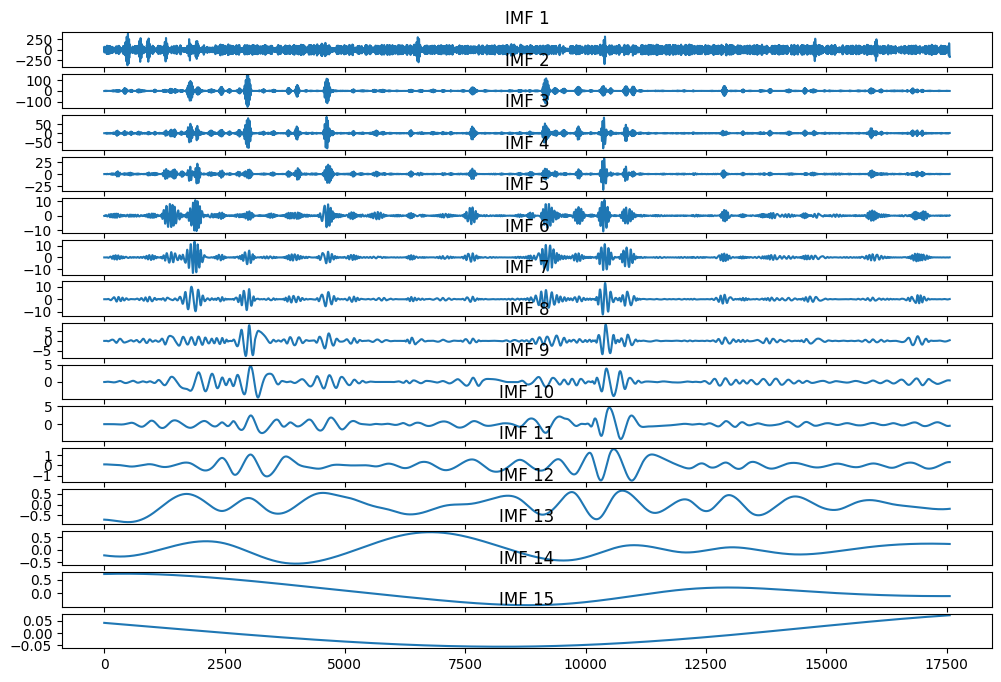

Epoch 1/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - loss: 0.0418 - mae: 0.1352 - val_loss: 0.0828 - val_mae: 0.2394
Epoch 2/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 64s 10ms/step - loss: 0.0111 - mae: 0.0610 - val_loss: 0.0830 - val_mae: 0.2397
Epoch 3/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 64s 10ms/step - loss: 0.0110 - mae: 0.0609 - val_loss: 0.0832 - val_mae: 0.2400
Epoch 4/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - loss: 0.0110 - mae: 0.0609 - val_loss: 0.0829 - val_mae: 0.2395
Epoch 5/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 66s 10ms/step - loss: 0.0111 - mae: 0.0609 - val_loss: 0.0826 - val_mae: 0.2392
Epoch 6/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 64s 10ms/step - loss: 0.0111 - mae: 0.0610 - val_loss: 0.0828 - val_mae: 0.2395
Epoch 7/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - loss: 0.0111 - mae: 0.0610 - val_loss: 0.0839 - val_mae: 0.2411
Epoch 8/50
6584/6584 ━━━━━━━━━━━━━━━━━━━━ 77s 8ms/step - loss: 0.0110 - mae: 0.0609 - val_loss: 0.0829 - val_mae: 0.2396
Epoch 9/50
6584/6584 ━━━━━━━

In [ ]:
# Ensure PyEMD is installed correctly, and restart the kernel if needed
!pip install PyEMD
!pip install EMD-signal

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Try importing PyEMD again after installation
from PyEMD.CEEMDAN import CEEMDAN
try:
    from PyEMD import CEEMDAN
except ImportError:
    print("PyEMD is not installed. Please make sure you have installed it using !pip install PyEMD and restart your kernel.")
    # If still facing issues, consider reinstalling:
    # !pip install --upgrade --force-reinstall PyEMD

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
# ... (rest of your code)

# Install necessary libraries
!pip install pyemd tensorflow scikit-learn matplotlib

# Step 1: Data Preprocessing
def preprocess_data(file_path):
    # Load dataset
    data = pd.read_csv(file_path)
    print("Dataset loaded.")

    # Visualize the dataset
    plt.figure(figsize=(12, 6))
    plt.plot(data.iloc[:, 0], label='Load Data')
    plt.legend()
    plt.show()

    # CEEMDAN Decomposition
    ceemdan = CEEMDAN()
    load_series = data.iloc[:, 1].values  # Assuming load is the second column
    IMFs = ceemdan(load_series)

    # Plot IMFs
    plt.figure(figsize=(12, 8))
    for i, imf in enumerate(IMFs):
        plt.subplot(len(IMFs), 1, i + 1)
        plt.plot(imf)
        plt.title(f'IMF {i + 1}')
    plt.tight_layout()
    plt.show()

    return IMFs

# Step 2: CLDNM Model
def create_cldnm(input_shape):
    """Create the CLDNM model combining LSTM and DNM layers."""
    input_layer = Input(shape=input_shape)

    # LSTM Layer
    lstm_out = LSTM(64, return_sequences=False)(input_layer)

    # Dendritic Neuron Layer (approximation using Dense and custom Lambda)
    def dendritic_layer(x):
        nonlinear_transform = tf.nn.relu(x)
        dendritic_product = tf.reduce_prod(nonlinear_transform, axis=-1, keepdims=True)
        return dendritic_product

    dnm_out = Lambda(dendritic_layer)(lstm_out)

    # Dense Output Layer
    output_layer = Dense(1, activation='linear')(dnm_out)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Step 3: Model Training and Evaluation
def train_and_evaluate_model(IMFs, epochs=50, batch_size=32):
    # Scaling the data
    scaler = MinMaxScaler()
    IMFs_scaled = [scaler.fit_transform(imf.reshape(-1, 1)) for imf in IMFs]

    # Create datasets
    X, y = [], []
    for imf in IMFs_scaled:
        for i in range(len(imf) - 10):  # Assuming time lag of 10
            X.append(imf[i:i + 10])
            y.append(imf[i + 10])

    X, y = np.array(X), np.array(y)

    # Model creation
    model = create_cldnm(input_shape=(X.shape[1], X.shape[2]))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    # Training
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    # Evaluation
    loss, mae = model.evaluate(X, y)
    print(f"Evaluation Results - Loss: {loss}, MAE: {mae}")

    return model

# Execution
if __name__ == "__main__":
    from google.colab import files

    # Upload dataset
    print("Please upload your dataset file.")
    uploaded = files.upload()

    # Get the uploaded file name
    dataset_path = list(uploaded.keys())[0]

    # Preprocess Data
    IMFs = preprocess_data(dataset_path)

    # Train and Evaluate Model
    model = train_and_evaluate_model(IMFs)
